# **Laboratorio 8**

- Derek Arreaga - 22537
- Mónica Salvatierra - 22249

Link del repo: https://github.com/alee2602/LAB8-DS

#### **Importación de librerías**

In [ ]:
import warnings, numpy as np, pandas as pd
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    precision_score, recall_score, confusion_matrix,
    roc_curve, precision_recall_curve
)

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


#### **Cargar CoverType**

In [3]:
cov = fetch_covtype(as_frame=True)
X_full: pd.DataFrame = cov.data.copy()
y_full: pd.Series = cov.target.copy()

#### **Exploración breve de features**

In [4]:

print("Número total de columnas:", X_full.shape[1])
print("\nPrimeras 10 columnas:")
print(X_full.columns[:10].tolist())

print("\nÚltimas 10 columnas:")
print(X_full.columns[-10:].tolist())

X_full.info()

X_full.head()


Número total de columnas: 54

Primeras 10 columnas:
['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']

Últimas 10 columnas:
['Soil_Type_30', 'Soil_Type_31', 'Soil_Type_32', 'Soil_Type_33', 'Soil_Type_34', 'Soil_Type_35', 'Soil_Type_36', 'Soil_Type_37', 'Soil_Type_38', 'Soil_Type_39']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 54 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Elevation                           581012 non-null  float64
 1   Aspect                              581012 non-null  float64
 2   Slope                               581012 non-null  float64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  float64
 4   Vertical_Distance_To_Hydr

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### **Distribución de la variable objetivo**

In [5]:

y_full.value_counts().sort_index()


Cover_Type
1    211840
2    283301
3     35754
4      2747
5      9493
6     17367
7     20510
Name: count, dtype: int64

#### **Descripción de las variables del conjunto de datos**

- `Elevation:` Representa la altitud del terreno en metros sobre el nivel del mar, con valores aproximados entre 1850 y 3858 m.

- `Aspect:` Indica la orientación del terreno en grados, donde 0–360° corresponden al ángulo  respecto al norte.

- `Slope:` Pendiente o inclinación del terreno expresada en grados, con un rango típico de 0–60°.

- `Hillshade_9am, Hillshade_Noon, Hillshade_3pm:` Miden el nivel de iluminación o sombra del terreno (valores entre 0 y 255) a distintas horas del día, calculados a partir de un modelo digital de elevación.

- `Horizontal_Distance_To_Hydrology / Vertical_Distance_To_Hydrology:` Distancias horizontales y verticales al cuerpo de agua más cercano, medidas en metros.

- `Horizontal_Distance_To_Roadways y Horizontal_Distance_To_Fire_Points:` Distancias horizontales hacia la carretera y al punto de incendio más cercano, respectivamente.

- `Wilderness_Area1–4:` Cuatro variables binarias (variables dummy) que identifican la zona silvestre a la que pertenece cada observación; solo una toma el valor 1 por registro.

- `Soil_Type1–40:` Cuarenta variables binarias que codifican el tipo de suelo; igualmente, solo una está activa (valor 1) para cada muestra.

- `Cover_Type:` Variable objetivo que clasifica la cobertura forestal en siete tipos (1–7). En este laboratorio, la clase 2 se considera “normal”, y las demás se tratan como anomalías. Por lo tanto, existe un desbalanceo grande entre clases.

#### **Etiquetar datos normales vs anómalos**

In [6]:
y = (y_full == 2).astype(int).values


#### **Definir columnas numéricas y binarias**

In [7]:
numeric_cols = [
    "Elevation", "Aspect", "Slope",
    "Horizontal_Distance_To_Hydrology", "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points",
]
binary_cols = [c for c in X_full.columns if c not in numeric_cols]

print("Numéricas:", len(numeric_cols))
print("Binarias:", len(binary_cols))

Numéricas: 10
Binarias: 44


#### **Escalar variables numéricas**

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

ct = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("bin", "passthrough", binary_cols),
    ],
    remainder="drop"
)

X = ct.fit_transform(X_full).astype("float32")

print("X shape:", X.shape)
print("Proporción de normales (y==1):", y.mean())

X shape: (581012, 54)
Proporción de normales (y==1): 0.48759922342395684


#### **Separación de conjuntos de entrenamiento, prueba y validación**

In [16]:

SEED = 16

idx_norm = np.where(y == 1)[0]
idx_anom = np.where(y == 0)[0]

# Normales: 60% Train, 10% Val, 10% TuneNorm, 20% TestNorm
idx_train_norm, idx_rest_norm = train_test_split(idx_norm, test_size=0.40, random_state=SEED, shuffle=True)
idx_val_norm, idx_rest_norm2 = train_test_split(idx_rest_norm, test_size=0.75, random_state=SEED, shuffle=True)   # 10% val
idx_tune_norm, idx_test_norm = train_test_split(idx_rest_norm2, test_size=0.6667, random_state=SEED, shuffle=True) # 10% tune, 20% test

# Anómalos: 70% Tune, 30% Test
idx_anom_tune, idx_anom_test = train_test_split(idx_anom, test_size=0.30, random_state=SEED, shuffle=True)

# Construcción de conjuntos
X_train = X[idx_train_norm];  y_train = y[idx_train_norm]               
X_val   = X[idx_val_norm];    y_val   = y[idx_val_norm]                 

# Tune mixto = TuneNorm + AnomTune
X_tune = np.vstack([X[idx_tune_norm], X[idx_anom_tune]])
y_tune = np.concatenate([y[idx_tune_norm], y[idx_anom_tune]])

# Test mixto = TestNorm + AnomTest
X_test = np.vstack([X[idx_test_norm], X[idx_anom_test]])
y_test = np.concatenate([y[idx_test_norm], y[idx_anom_test]])

print("Shapes:")
print("  X_train:", X_train.shape, " y_train sum:", y_train.sum())  
print("  X_val  :", X_val.shape,   " y_val sum:",   y_val.sum())    
print("  X_tune :", X_tune.shape,  " proporción normales:", y_tune.mean())
print("  X_test :", X_test.shape,  " proporción normales:", y_test.mean())

Shapes:
  X_train: (169980, 54)  y_train sum: 169980
  X_val  : (28330, 54)  y_val sum: 28330
  X_tune : (236724, 54)  proporción normales: 0.11966256061911762
  X_test : (145978, 54)  proporción normales: 0.38816808012166215


En los autocodificadores, el objetivo principal es que el modelo aprenda a reconstruir correctamente los patrones normales de los datos. Por esa razón, los conjuntos de entrenamiento y validación deben incluir únicamente observaciones normales. Si el modelo se entrena con ejemplos anómalos, también aprendería a reconstruir esos comportamientos atípicos y dejaría de distinguirlos del resto, perdiendo su capacidad para detectar anomalías. En cambio, al entrenarlo solo con datos normales, el error de reconstrucción aumenta significativamente cuando se encuentra con observaciones inusuales, lo que permite utilizarlas como indicador de anomalía. Por este motivo, únicamente el conjunto de prueba debe contener tanto observaciones normales como anómalas, ya que se usa para evaluar qué tan bien el modelo logra diferenciarlas.

#### **Utilidades comunes para la evaluación de los modelos**

In [17]:

def precision_at_k(scores_anom, y_true_anom, k):
    order = np.argsort(-scores_anom)    
    topk = order[:k]
    return float(y_true_anom[topk].mean())

def best_f1_threshold(scores_anom, y_true_anom, n_steps=200, greater_is_anom=True):
    ths = np.linspace(scores_anom.min(), scores_anom.max(), n_steps)
    best = (0.0, ths[0], 0.0, 0.0)  # f1, th, p, r
    for th in ths:
        y_hat = (scores_anom >= th).astype(int) if greater_is_anom else (scores_anom <= th).astype(int)
        f1 = f1_score(y_true_anom, y_hat, zero_division=0)
        if f1 > best[0]:
            p = precision_score(y_true_anom, y_hat, zero_division=0)
            r = recall_score(y_true_anom, y_hat, zero_division=0)
            best = (f1, th, p, r)
    return {"F1": best[0], "th": best[1], "P": best[2], "R": best[3]}

def plot_roc_pr(y_true_anom, scores, title_prefix):
    fpr, tpr, _ = roc_curve(y_true_anom, scores)
    plt.figure(); plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'--')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"{title_prefix} · ROC"); plt.show()

    p, r, _ = precision_recall_curve(y_true_anom, scores)
    plt.figure(); plt.plot(r, p)
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"{title_prefix} · Precision-Recall"); plt.show()

def eval_with_threshold(scores_anom, y_true_anom, th):
    y_hat = (scores_anom >= th).astype(int)
    return {
        "F1": f1_score(y_true_anom, y_hat, zero_division=0),
        "ROC-AUC": roc_auc_score(y_true_anom, scores_anom),
        "PR-AUC": average_precision_score(y_true_anom, scores_anom),
        "CM": confusion_matrix(y_true_anom, y_hat),
        "y_hat": y_hat
    }


#### **Autoencoder simétrico**

In [18]:

input_dim = X_train.shape[1]

def build_autoencoder(d):
    inputs = keras.Input(shape=(d,))
    x = layers.Dense(64, activation="relu")(inputs)
    x = layers.Dense(32, activation="relu")(x)
    bottleneck = layers.Dense(16, activation="relu")(x)
    x = layers.Dense(32, activation="relu")(bottleneck)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(d, activation="linear")(x)
    ae = keras.Model(inputs, outputs)
    ae.compile(optimizer="adam", loss="mse")
    return ae

ae = build_autoencoder(input_dim)
early = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

hist = ae.fit(
    X_train, X_train,
    validation_data=(X_val, X_val),
    epochs=100, batch_size=512, callbacks=[early], verbose=1
)

print("Mejor val_loss:", np.min(hist.history["val_loss"]))


Epoch 1/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0523 - val_loss: 0.0157
Epoch 2/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0112 - val_loss: 0.0083
Epoch 3/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0066 - val_loss: 0.0052
Epoch 4/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0042 - val_loss: 0.0034
Epoch 5/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 6/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 7/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 8/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 9/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 10/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 11/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 12/100
332/332 ━━━━━━━━━━━━━━━━━━━━

#### **Evaluación del Autoencoder**

AE th_percentil95=0.015155  | AE th_F1=0.000014  (Tune F1=0.936)
AE (percentil): {'F1': 0.3425599942520477, 'ROC-AUC': 0.7167684055610144, 'PR-AUC': 0.8022073257862314}
CM (percentil):
 [[53705  2959]
 [70243 19071]]
AE (F1 tune): {'F1': 0.7591758325824932, 'ROC-AUC': 0.7167684055610144, 'PR-AUC': 0.8022073257862314}
CM (F1 tune):
 [[    0 56664]
 [    0 89314]]


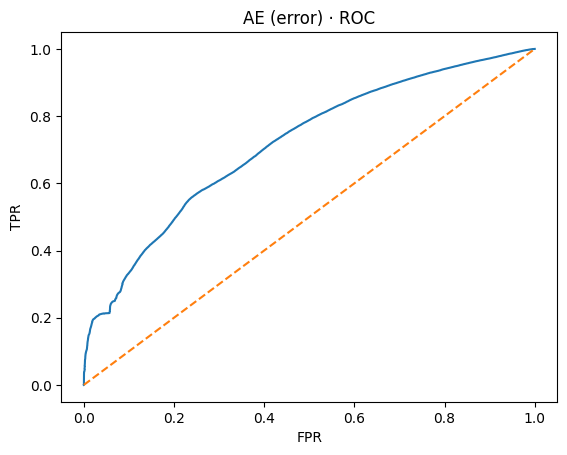

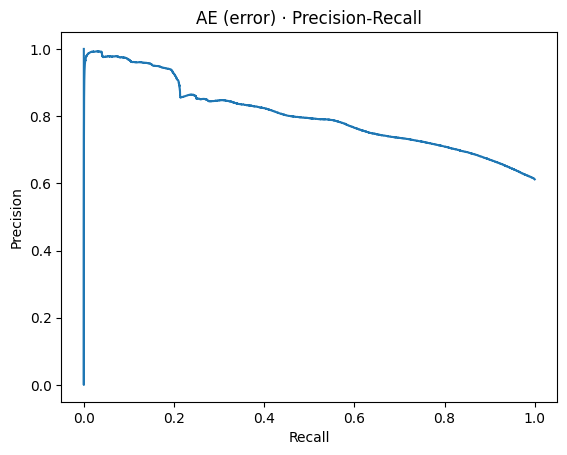

In [19]:
def recon_error(model, Xarr):
    X_hat = model.predict(Xarr, verbose=0)
    return np.mean(np.square(Xarr - X_hat), axis=1)

err_val  = recon_error(ae, X_val)    
err_tune = recon_error(ae, X_tune)   
err_test = recon_error(ae, X_test)   

# Umbrales
th_pct = float(np.percentile(err_val, 95.0))         
best   = best_f1_threshold(err_tune, (1 - y_tune), n_steps=200, greater_is_anom=True)
th_f1  = best["th"]

print(f"AE th_percentil95={th_pct:.6f}  | AE th_F1={th_f1:.6f}  (Tune F1={best['F1']:.3f})")

# Evaluación en Test
ae_pct = eval_with_threshold(err_test, (1 - y_test), th_pct)
ae_f1  = eval_with_threshold(err_test, (1 - y_test), th_f1)

print("AE (percentil):", {k:v for k,v in ae_pct.items() if k!='CM' and k!='y_hat'})
print("CM (percentil):\n", ae_pct["CM"])
print("AE (F1 tune):", {k:v for k,v in ae_f1.items() if k!='CM' and k!='y_hat'})
print("CM (F1 tune):\n", ae_f1["CM"])

# Curvas usando el score de anomalía 
plot_roc_pr((1 - y_test), err_test, "AE (error)")

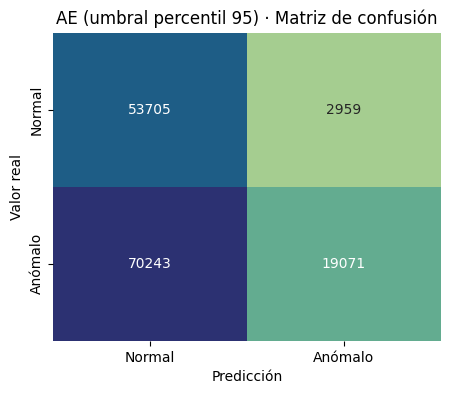

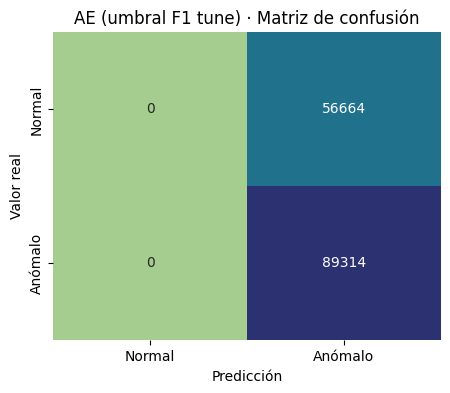

In [49]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_heatmap(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(
        cm,
        annot=True, fmt="d", cmap="crest", cbar=False,
        xticklabels=["Normal", "Anómalo"], yticklabels=["Normal", "Anómalo"]
    )
    plt.title(title)
    plt.xlabel("Predicción")
    plt.ylabel("Valor real")
    plt.show()

plot_confusion_heatmap((1 - y_test), ae_pct["y_hat"], "AE (umbral percentil 95) · Matriz de confusión")
plot_confusion_heatmap((1 - y_test), ae_f1["y_hat"], "AE (umbral F1 tune) · Matriz de confusión")

#### **Entrenamiento con Isolation Forest**

In [47]:
grid = {
    "n_estimators": [100, 200, 300],
    "max_samples": ["auto", 1024, 2048],
    "max_features": [0.5, 1.0]
}

candidatos = []
for n in grid["n_estimators"]:
    for ms in grid["max_samples"]:
        for mf in grid["max_features"]:
            if_model = IsolationForest(
                n_estimators=n, max_samples=ms, max_features=mf,
                contamination="auto", random_state=SEED, n_jobs=-1
            ).fit(X_train)

            # Scores de anomalía 
            s_tune = -if_model.decision_function(X_tune)
            s_test = -if_model.decision_function(X_test)

            # Umbral por F1 en Tune
            best = best_f1_threshold(s_tune, (1 - y_tune), n_steps=200, greater_is_anom=True)
            th = best["th"]

            # Métricas en Test
            ev = eval_with_threshold(s_test, (1 - y_test), th)
            candidatos.append({
                "params": {"n_estimators": n, "max_samples": ms, "max_features": mf},
                "th": th, "eval": ev, "s_test": s_test
            })

# Elegir el mejor por F1 en Test
mejor = max(candidatos, key=lambda c: c["eval"]["F1"])
p = mejor["params"]; th_if = mejor["th"]; if_eval = mejor["eval"]; s_test_if = mejor["s_test"]


#### **Mostrar métricas de entrenamiento para Isolation Forest**

>>> Isolation Forest (MEJOR por F1)
Parámetros: {'n_estimators': 100, 'max_samples': 'auto', 'max_features': 0.5} | Umbral(F1 Tune): -0.151893792434666
{'F1': 0.7591758325824932, 'ROC-AUC': 0.6340325562470167, 'PR-AUC': 0.7283078352609317}


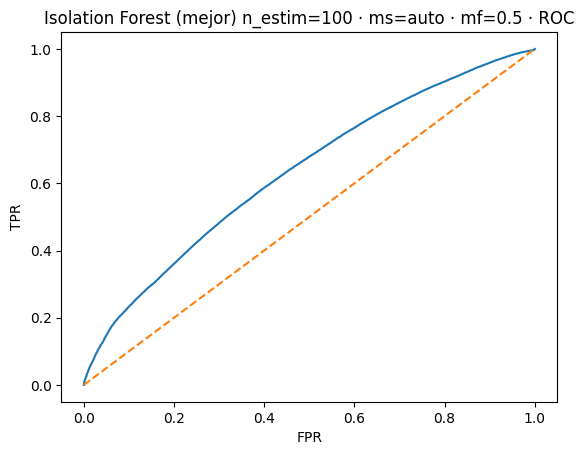

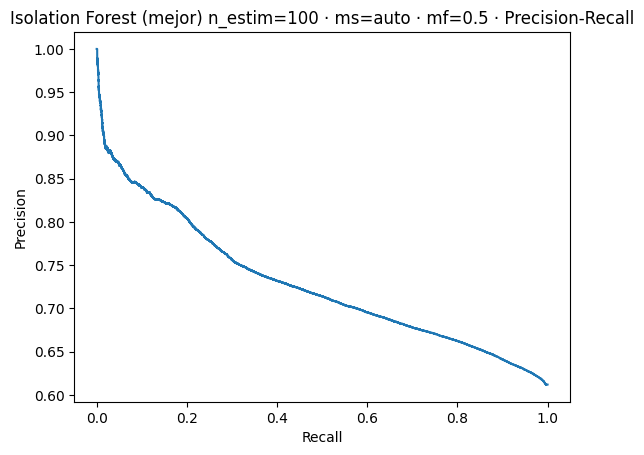

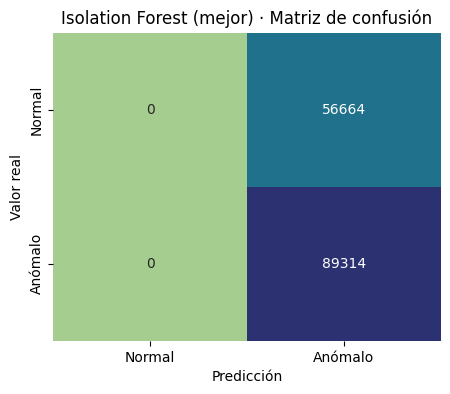

Isolation Forest (mejor) Precision@1459: 0.9026730637422893


In [50]:
print(">>> Isolation Forest (MEJOR por F1)")
print("Parámetros:", p, "| Umbral(F1 Tune):", th_if)
print({k:v for k,v in if_eval.items() if k not in ["CM","y_hat"]})

plot_roc_pr((1 - y_test), s_test_if, f"Isolation Forest (mejor) n_estim={p['n_estimators']} · ms={p['max_samples']} · mf={p['max_features']}")
cm_if = plot_confusion_heatmap((1 - y_test), if_eval["y_hat"], "Isolation Forest (mejor) · Matriz de confusión")

# Precision@k del mejor
k = max(1, int(0.01 * len(y_test)))
print(f"Isolation Forest (mejor) Precision@{k}:", precision_at_k(s_test_if, (1 - y_test), k))

#### **Entrenamiento con LOF**

In [51]:

neighbors_grid = [15, 25, 35, 50]

candidatos = []
for nn in neighbors_grid:
    lof = LocalOutlierFactor(n_neighbors=nn, novelty=True, contamination="auto").fit(X_train)

    s_tune = -lof.decision_function(X_tune)
    s_test = -lof.decision_function(X_test)

    # Umbral por F1 en Tune
    best = best_f1_threshold(s_tune, (1 - y_tune), n_steps=200, greater_is_anom=True)
    th = best["th"]

    # Métricas en Test
    ev = eval_with_threshold(s_test, (1 - y_test), th)
    candidatos.append({"nn": nn, "th": th, "eval": ev, "s_test": s_test})

# Elegir el mejor por F1 en Test
mejor = max(candidatos, key=lambda c: c["eval"]["F1"])
nn_best = mejor["nn"]; th_lof = mejor["th"]; lof_eval = mejor["eval"]; s_test_lof = mejor["s_test"]



>>> LOF (MEJOR por F1)
n_neighbors=15 | Umbral(F1 Tune): -0.4821498394012451
{'F1': 0.8161365399534523, 'ROC-AUC': 0.8884447459282652, 'PR-AUC': 0.9318502629779885}


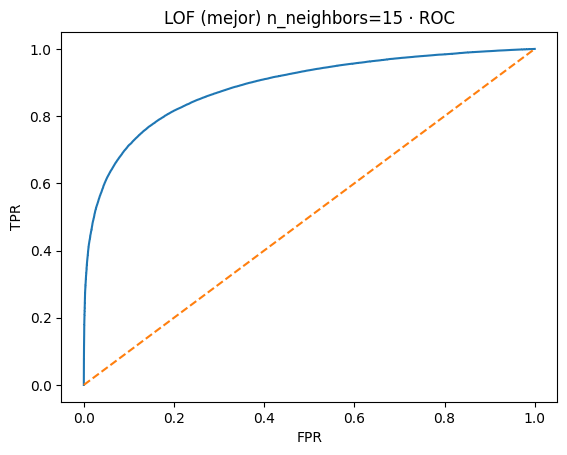

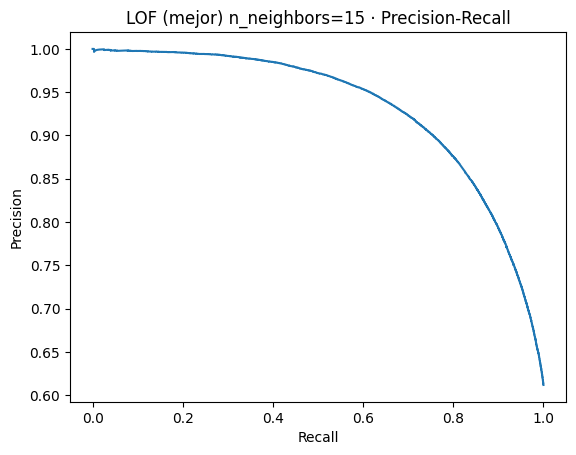

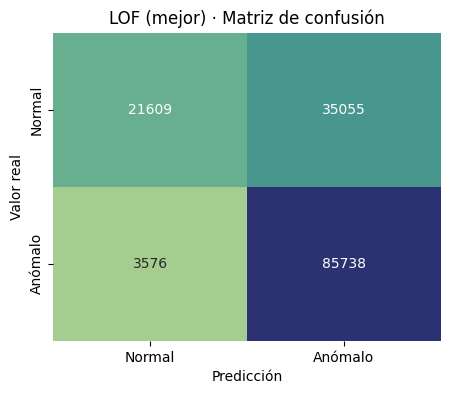

LOF (mejor) Precision@1459: 0.9993145990404386


In [52]:
print(">>> LOF (MEJOR por F1)")
print(f"n_neighbors={nn_best} | Umbral(F1 Tune): {th_lof}")
print({k:v for k,v in lof_eval.items() if k not in ["CM","y_hat"]})

# Gráficos SOLO del mejor
plot_roc_pr((1 - y_test), s_test_lof, f"LOF (mejor) n_neighbors={nn_best}")
cm_lof = plot_confusion_heatmap((1 - y_test), lof_eval["y_hat"], "LOF (mejor) · Matriz de confusión")

# Precision@k del mejor
k = max(1, int(0.01 * len(y_test)))
print(f"LOF (mejor) Precision@{k}:", precision_at_k(s_test_lof, (1 - y_test), k))

#### **Comparación y mejor modelo**

In [53]:
k = max(1, int(0.01 * len(y_test)))

rows = [
    ("AE (percentil)", ae_pct["F1"], ae_pct["ROC-AUC"], ae_pct["PR-AUC"], precision_at_k(err_test, (1 - y_test), k), ae_pct["CM"]),
    ("AE (F1 tune)",  ae_f1["F1"],  ae_f1["ROC-AUC"],  ae_f1["PR-AUC"],  precision_at_k(err_test, (1 - y_test), k), ae_f1["CM"]),
    ("Isolation Forest", if_eval["F1"], if_eval["ROC-AUC"], if_eval["PR-AUC"], precision_at_k(s_test_if, (1 - y_test), k), if_eval["CM"]),
    ("LOF", lof_eval["F1"], lof_eval["ROC-AUC"], lof_eval["PR-AUC"], precision_at_k(s_test_lof, (1 - y_test), k), lof_eval["CM"]),
]
df = pd.DataFrame(rows, columns=["Modelo","F1","ROC-AUC","PR-AUC",f"Precision@{k}","CM"])
display(df[["Modelo","F1","ROC-AUC","PR-AUC",f"Precision@{k}"]])

# Elegir mejor por F1 
best_idx = df["F1"].idxmax()
best_name = df.loc[best_idx, "Modelo"]
best_cm = df.loc[best_idx, "CM"]
print(f"\n>>> MEJOR MODELO (por F1): {best_name}")
print("Matriz de confusión del mejor modelo:\n", best_cm)

,Modelo,F1,ROC-AUC,PR-AUC,Precision@1459
0,AE (percentil),0.342560,0.716768,0.802207,0.991090
1,AE (F1 tune),0.759176,0.716768,0.802207,0.991090
2,Isolation Forest,0.759176,0.634033,0.728308,0.902673
3,LOF,0.816137,0.888445,0.931850,0.999315



>>> MEJOR MODELO (por F1): LOF
Matriz de confusión del mejor modelo:
 [[21609 35055]
 [ 3576 85738]]


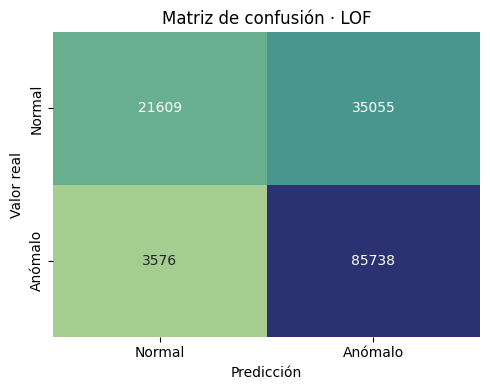

In [54]:
def plot_cm_heatmap(cm, title):
    plt.figure(figsize=(5,4))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="crest", cbar=False,
        xticklabels=["Normal", "Anómalo"], yticklabels=["Normal", "Anómalo"]
    )
    plt.title(title)
    plt.xlabel("Predicción")
    plt.ylabel("Valor real")
    plt.tight_layout()
    plt.show()

# Heatmap del mejor modelo 
plot_cm_heatmap(best_cm, f"Matriz de confusión · {best_name}")
